In [27]:
# %% -------------------- Imports and Setup --------------------
import pandas as pd
import numpy as np
import sys
import pathlib
import random
import joblib
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# Set seed for reproducibility
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

# Setup path
project_root = pathlib.Path().resolve().parent
sys.path.append(str(project_root / 'src'))

import util


In [28]:

# %% -------------------- Load and Preprocess Data --------------------
train_df, test_df = util.load_data('../data/train.csv', '../data/test.csv')

# Separate target
target = 'rainfall'
train_y = train_df[target]
train_X = train_df.drop(columns=[target, 'id'])
test_df_no_id = test_df.drop(columns=['id'])

# Preprocess data
df_train, df_test = util.preprocess_train_test(train_X, test_df_no_id)

# %% -------------------- Load Models and Feature Sets --------------------
lgbm_data = joblib.load('lightgbm_optuna_with_features.pkl')
xgb_data = joblib.load('xgb_optuna_with_features.pkl')
cat_model = joblib.load('catboost_optuna_with_features.pkl')  # Loaded directly as model

lgbm_model = lgbm_data['model']
lgbm_features = lgbm_data['features']

xgb_model = xgb_data['model']
xgb_features = xgb_data['features']

cat_features = list(df_train.columns)  # Assuming CatBoost used all columns

# %% -------------------- Prepare Meta Model Inputs --------------------
# Train-validation split for meta-model
X_train, X_meta, y_train, y_meta = train_test_split(df_train, train_y, test_size=0.2, stratify=train_y, random_state=SEED)

# Base model predictions for meta-input
lgbm_preds_meta = lgbm_model.predict_proba(X_meta[lgbm_features])[:, 1]
xgb_preds_meta = xgb_model.predict_proba(X_meta[xgb_features])[:, 1]
cat_preds_meta = cat_model.predict_proba(X_meta[cat_features])[:, 1]

# Create DataFrame for meta-model
meta_X = pd.DataFrame({
    'lgbm_preds': lgbm_preds_meta,
    'xgb_preds': xgb_preds_meta,
    'cat_preds': cat_preds_meta
})

# %% -------------------- Meta-Model Training and AUC Comparison --------------------
meta_models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=SEED),
    'XGBoost': XGBClassifier(n_estimators=200, learning_rate=0.05, max_depth=3, random_state=SEED, eval_metric='logloss', use_label_encoder=False),
    'LightGBM': LGBMClassifier(n_estimators=200, learning_rate=0.05, max_depth=3, random_state=SEED)
}

meta_results = {}

for name, meta_model in meta_models.items():
    meta_model.fit(meta_X, y_meta)
    meta_preds = meta_model.predict_proba(meta_X)[:, 1]
    auc_score = roc_auc_score(y_meta, meta_preds)
    meta_results[name] = auc_score
    print(f"{name} Meta-Model AUC: {auc_score:.4f}")


Train shape: (2190, 13), Test shape: (730, 12)
[LightGBM] [Warning] min_data_in_leaf is set=51, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=51
[LightGBM] [Warning] feature_fraction is set=0.7048106210640472, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7048106210640472
[LightGBM] [Warning] lambda_l1 is set=0.43113207298492334, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.43113207298492334
[LightGBM] [Warning] lambda_l2 is set=1.6368965509101188, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6368965509101188
[LightGBM] [Warning] bagging_fraction is set=0.5948159528332612, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5948159528332612
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
Logistic Regression Meta-Model AUC: 0.9198
XGBoost Meta-Model AUC: 0.9831
[LightGBM] [Info] Number of positive: 330, number of negative: 108
[LightGBM] [

c:\Users\ronni\anaconda3\envs\backpackv2\Lib\site-packages\xgboost\core.py:158: UserWarning: [09:37:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


C:\Users\ronni\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


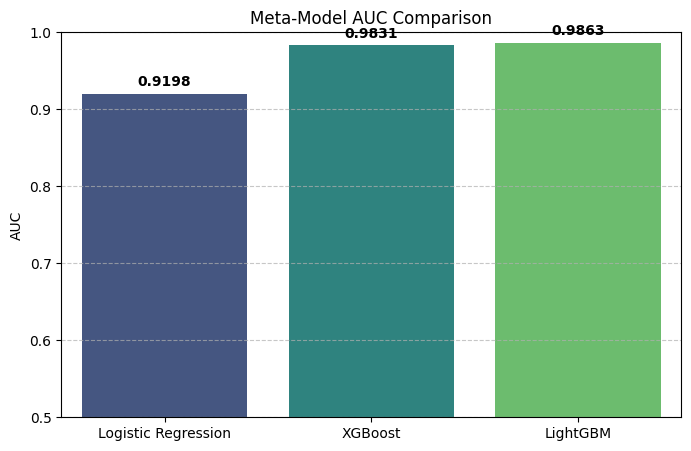

In [29]:

# %% -------------------- Plot Meta-Model AUC --------------------
plt.figure(figsize=(8, 5))
sns.barplot(x=list(meta_results.keys()), y=list(meta_results.values()), palette='viridis')
plt.title('Meta-Model AUC Comparison')
plt.ylabel('AUC')
plt.ylim(0.5, 1.0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
for i, v in enumerate(meta_results.values()):
    plt.text(i, v + 0.01, f"{v:.4f}", ha='center', fontweight='bold')
plt.show()


In [30]:

# %% -------------------- Final Ensemble Prediction --------------------
# Base model test predictions
lgbm_test_preds = lgbm_model.predict_proba(df_test[lgbm_features])[:, 1]
xgb_test_preds = xgb_model.predict_proba(df_test[xgb_features])[:, 1]
cat_test_preds = cat_model.predict_proba(df_test[cat_features])[:, 1]

# Meta input for test
meta_test_X = pd.DataFrame({
    'lgbm_preds': lgbm_test_preds,
    'xgb_preds': xgb_test_preds,
    'cat_preds': cat_test_preds
})

# Choose best meta-model (example: Logistic Regression)
final_meta_model = LogisticRegression(max_iter=1000, random_state=SEED)
final_meta_model.fit(meta_X, y_meta)
final_test_probs = final_meta_model.predict_proba(meta_test_X)[:, 1]

# Write final submission
util.write_submission(test_df, final_test_probs, id_column='id', output_path='submission_stacked_ensemble.csv', prediction_column='rainfall')
print("Stacked ensemble submission written to 'submission_stacked_ensemble.csv'")


[LightGBM] [Warning] min_data_in_leaf is set=51, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=51
[LightGBM] [Warning] feature_fraction is set=0.7048106210640472, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7048106210640472
[LightGBM] [Warning] lambda_l1 is set=0.43113207298492334, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.43113207298492334
[LightGBM] [Warning] lambda_l2 is set=1.6368965509101188, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6368965509101188
[LightGBM] [Warning] bagging_fraction is set=0.5948159528332612, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5948159528332612
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
Submission file written to: submission_stacked_ensemble.csv
Stacked ensemble submission written to 'submission_stacked_ensemble.csv'


In [31]:
# print final auc
final_auc = roc_auc_score(y_meta, final_meta_model.predict_proba(meta_X)[:, 1])
print(f"Final Stacked Ensemble AUC: {final_auc:.4f}")

Final Stacked Ensemble AUC: 0.9198
